In [74]:
from autograd import numpy as np
import autograd.numpy.random as npr
from autograd import grad
from autograd.misc.optimizers import adam, sgd, rmsprop
#from autograd import scipy as sp
import numpy
import matplotlib.pyplot as plt
import sys

sigmoid = lambda x: 1/(1+np.exp(-x))
w1 = lambda x: np.sin(2 * np.pi * x/4)
w2 = lambda x: 3*np.exp(-0.5*((x-1)/0.6)**2)
w3 = lambda x: 3*sigmoid((x-1)/0.3)

def trial1(z):
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

def p1(z):
    '''Apply posterior p_1 to bivariate z.'''
    z1, z2 = z[:, 0], z[:, 1]
    first = (np.linalg.norm(z, 2, 1) - 2)/0.4
    exp1 = np.exp(-0.5*((z1 - 2)/0.6)**2)
    exp2 = np.exp(-0.5*((z1 + 2)/0.6)**2)
    u = 0.5*first**2 - np.log(exp1 + exp2)
    return np.exp(-u)

def p2(z):
    '''Apply posterior p_2 to bivariate z.'''
    z1, z2 = z[:, 0], z[:, 1]
    u = 0.5 * ((z2 - w1(z1))/0.4) ** 2
    dummy = np.ones(u.shape) * 1e7
    u = np.where(np.abs(z1) <= 4, u, dummy)
    return np.exp(-u)

def p3(z):
    '''Apply posterior p_3 to bivariate z.'''
    z1, z2 = z[:, 0], z[:, 1]
    exp1 = np.exp(-0.5*((z2 - w1(z1))/0.35)**2)
    exp2 = np.exp(-0.5*((z2 - w1(z1) + w2(z1))/0.35)**2)
    u = - np.log(exp1 + exp2)
    return np.exp(-u)

def p4(z):
    '''Apply posterior p_4 to bivariate z.'''
    z1, z2 = z[:, 0], z[:, 1]
    exp1 = np.exp(-0.5*((z2 - w1(z1))/0.4)**2)
    exp2 = np.exp(-0.5*((z2 - w1(z1) + w3(z1))/0.35)**2)
    u = - np.log(exp1 + exp2)
    return np.exp(-u)

def gmm(z):
    gauss_uni = lambda x, mu, sigma: 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*((x-mu)/sigma)**2)
    pi = np.array([0.3, 0.7])
    mu = np.array([-1.5, 1.5])
    sigma = np.array([1 , 1])
    return pi[0]*gauss_uni(z, mu[0], sigma[0]) + pi[1]*gauss_uni(z, mu[1], sigma[1])

m = lambda x: -1 + np.log(1 + np.exp(x))
h = lambda x: np.tanh(x)
h_prime = lambda x: 1 - np.tanh(x)**2


def gradient_create(target, eps, dim_z, num_samples, K):

    def unpack_params(params):
        W = params[:K*dim_z].reshape(K,dim_z)
        U = params[K*dim_z:2*K*dim_z].reshape(K,dim_z)
        B = params[-K:]
        return W,U,B

    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        W,U,B = unpack_params(params)
        z0 = np.random.multivariate_normal(np.zeros(dim_z), np.eye(dim_z),
                num_samples)
        z_prev = z0
        sum_log_det_jacob = 0.
        for k in range(K):
            w, u, b = W[k], U[k], B[k]
            u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
            affine = np.outer(h_prime(np.matmul(z_prev, w) + b), w)
            sum_log_det_jacob += np.log(eps + np.abs(1 + np.matmul(affine, u)))
            z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
        z_K = z_prev
        log_q_K = -0.5 * np.sum(np.log(2*np.pi) + z0**2, 1) - sum_log_det_jacob
        log_p = np.log(eps + target(z_K))
        return np.mean(log_q_K - log_p)

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

Iteration 0; Gradient mag: 1.2903990308303066; Objective: 11.915458248677828


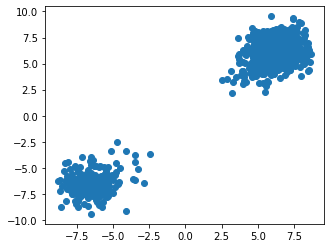

Iteration 100; Gradient mag: 1.4100143192736003; Objective: 11.797973412509554
Iteration 200; Gradient mag: 3.641901689676572; Objective: 11.044795349159257
Iteration 300; Gradient mag: 16.843814481765197; Objective: 5.423282076787385
Iteration 400; Gradient mag: 7.769590589563639; Objective: -1.3484570653956593
Iteration 500; Gradient mag: 2.2538291339941665; Objective: -1.9609730928647924
Iteration 600; Gradient mag: 3.1402888771188238; Objective: -2.4279968707554525
Iteration 700; Gradient mag: 4.495524264970629; Objective: -3.212833335672806
Iteration 800; Gradient mag: 5.045521888731681; Objective: -5.067146391165652
Iteration 900; Gradient mag: 5.456606331045281; Objective: -6.561043282924726
Iteration 1000; Gradient mag: 5.283743271615396; Objective: -8.616765797352862
Iteration 1100; Gradient mag: 4.520820450075514; Objective: -9.789587187916576
Iteration 1200; Gradient mag: 3.659900194363684; Objective: -10.802186353948008
Iteration 1300; Gradient mag: 2.503512668485006; Objec

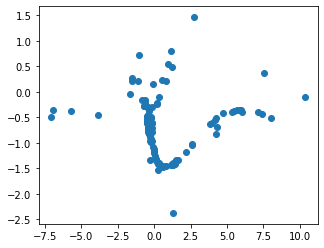

Iteration 5100; Gradient mag: 658.0003778212742; Objective: -23.897988604717124
Iteration 5200; Gradient mag: 72.30643417198641; Objective: -24.67486841667118
Iteration 5300; Gradient mag: 44.45839922765098; Objective: -24.754422547206545
Iteration 5400; Gradient mag: 144.72321764288486; Objective: -24.90817384316383
Iteration 5500; Gradient mag: 40.0050998087514; Objective: -25.08104856999775
Iteration 5600; Gradient mag: 7.531304592907936; Objective: -25.481944905149966
Iteration 5700; Gradient mag: 169.64156467460407; Objective: -25.592366043737325
Iteration 5800; Gradient mag: 88.96685210956116; Objective: -25.617290766576843
Iteration 5900; Gradient mag: 124.11961766275557; Objective: -26.117961434278193
Iteration 6000; Gradient mag: 214.0710303153549; Objective: -26.09038160163579
Iteration 6100; Gradient mag: 153.87608995829677; Objective: -26.39152278405472
Iteration 6200; Gradient mag: 77.70928390763166; Objective: -26.47883481551722
Iteration 6300; Gradient mag: 165.864994740

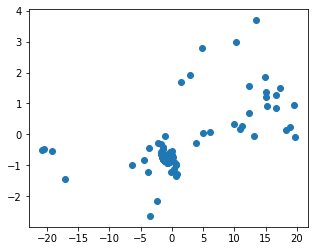

Iteration 10100; Gradient mag: 1120.7189852409642; Objective: -28.481324310196463
Iteration 10200; Gradient mag: 888.4212195910276; Objective: -18.47701148326801
Iteration 10300; Gradient mag: 168.29097446108372; Objective: -8.713584590014475
Iteration 10400; Gradient mag: 4975.710213280828; Objective: -25.913538654903878
Iteration 10500; Gradient mag: 4904.016783000868; Objective: -26.10242218762165
Iteration 10600; Gradient mag: 37.351930658518036; Objective: -24.97844028465989
Iteration 10700; Gradient mag: 1838.3356007079167; Objective: -23.03235597254916
Iteration 10800; Gradient mag: 319.33727204610096; Objective: -26.863866077120267
Iteration 10900; Gradient mag: 2183.795548190374; Objective: -26.17947796935312
Iteration 11000; Gradient mag: 5483.31104733823; Objective: -17.727038887104438
Iteration 11100; Gradient mag: 1652.1236837351346; Objective: -25.922736909799152
Iteration 11200; Gradient mag: 1937.2151716409746; Objective: -26.63195964691491
Iteration 11300; Gradient mag

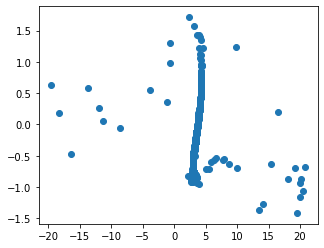

Iteration 15100; Gradient mag: 57.73506264180315; Objective: -25.955940868997807
Iteration 15200; Gradient mag: 624.2181951336331; Objective: -26.263404556914875
Iteration 15300; Gradient mag: 6017.745300907794; Objective: -27.357946969060457
Iteration 15400; Gradient mag: 2321.7899681804456; Objective: -27.070212696067873
Iteration 15500; Gradient mag: 46.25275199192398; Objective: -25.814203333573882
Iteration 15600; Gradient mag: 4331.13822234652; Objective: -27.45385139561435
Iteration 15700; Gradient mag: 6102.979516339702; Objective: -27.677472733033685
Iteration 15800; Gradient mag: 1478.8472427354282; Objective: -27.249124379426167
Iteration 15900; Gradient mag: 248.72738542049757; Objective: -27.376873301963418
Iteration 16000; Gradient mag: 6082.1366924036765; Objective: -27.61860027087879
Iteration 16100; Gradient mag: 3148.4916549491313; Objective: -27.889653123111835
Iteration 16200; Gradient mag: 3279.913740041393; Objective: -27.8507168501719
Iteration 16300; Gradient ma

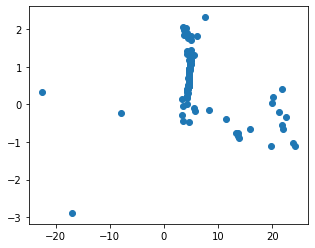

Iteration 20100; Gradient mag: 1019.5309204877196; Objective: -27.826298198458474
Iteration 20200; Gradient mag: 208.82454972020238; Objective: -28.32341938042061
Iteration 20300; Gradient mag: 1009.7287833700634; Objective: -27.846964511328732
Iteration 20400; Gradient mag: 2025.8642201270773; Objective: -28.080324521020245
Iteration 20500; Gradient mag: 969.5906600735638; Objective: -27.757542697990427
Iteration 20600; Gradient mag: 1364.2231164140724; Objective: -27.96728251003934
Iteration 20700; Gradient mag: 1248.3834462006007; Objective: -27.832134574004897
Iteration 20800; Gradient mag: 14265.591481470045; Objective: -27.766002777115574
Iteration 20900; Gradient mag: 3432.922416904218; Objective: -28.244634795121694
Iteration 21000; Gradient mag: 1294.8401381249457; Objective: -27.765488526173304
Iteration 21100; Gradient mag: 1885.8052653720206; Objective: -28.2889038778489
Iteration 21200; Gradient mag: 1776.4499455521652; Objective: -28.659954664642072
Iteration 21300; Gradi

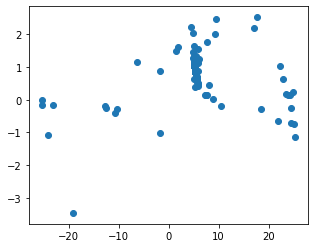

Iteration 25100; Gradient mag: 1996.8343360950848; Objective: -28.954348034188925
Iteration 25200; Gradient mag: 790.9856428537026; Objective: -29.12104626740522
Iteration 25300; Gradient mag: 118.86069993479873; Objective: -28.563063645179373
Iteration 25400; Gradient mag: 341.0876736016871; Objective: -29.169536444776455
Iteration 25500; Gradient mag: 4677.165359326954; Objective: -29.013094441959918
Iteration 25600; Gradient mag: 5101.7233836823925; Objective: -29.044100097923522
Iteration 25700; Gradient mag: 3282.9238992682713; Objective: -29.0671873296493
Iteration 25800; Gradient mag: 1127.5464827292462; Objective: -28.494392885171546
Iteration 25900; Gradient mag: 2083.6958360503477; Objective: -28.85938176448176
Iteration 26000; Gradient mag: 1393.1736505537822; Objective: -29.13675573783184
Iteration 26100; Gradient mag: 7843.7845249912; Objective: -27.286325166629563
Iteration 26200; Gradient mag: 1069.282721173038; Objective: -28.90055832633424
Iteration 26300; Gradient mag

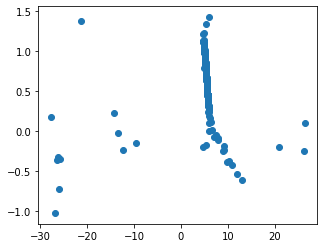

Iteration 30100; Gradient mag: 5710.94913451892; Objective: -29.13939704740036
Iteration 30200; Gradient mag: 588.343175610975; Objective: -29.27222277876016
Iteration 30300; Gradient mag: 134.65304936662676; Objective: -9.573356341098203
Iteration 30400; Gradient mag: 2873.85863824997; Objective: -25.682697487294107
Iteration 30500; Gradient mag: 99.74892409120629; Objective: -25.559717115614593
Iteration 30600; Gradient mag: 263.8399513382058; Objective: -25.23249505705903
Iteration 30700; Gradient mag: 94.93542506233781; Objective: -25.88368108424746
Iteration 30800; Gradient mag: 1805.0965863289412; Objective: -25.934430157526368
Iteration 30900; Gradient mag: 442.220515292977; Objective: -25.861856142602765
Iteration 31000; Gradient mag: 944.7086361341703; Objective: -25.49918940158832
Iteration 31100; Gradient mag: 3304.935293282086; Objective: -26.235636149663232
Iteration 31200; Gradient mag: 167.79177286778233; Objective: -26.313417792758177
Iteration 31300; Gradient mag: 138.

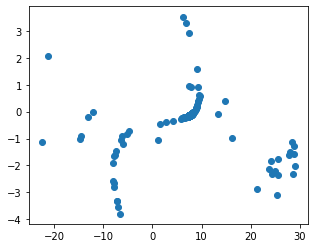

Iteration 35100; Gradient mag: 1177.3080837327839; Objective: -27.59143780816548
Iteration 35200; Gradient mag: 879.9659523435034; Objective: -28.425283054790274
Iteration 35300; Gradient mag: 160.1523278796268; Objective: -27.146828441504958
Iteration 35400; Gradient mag: 1035.2641074604373; Objective: -28.068743775337587
Iteration 35500; Gradient mag: 990.5754164644671; Objective: -28.263851287319383
Iteration 35600; Gradient mag: 613.8224106865339; Objective: -26.861042940546476
Iteration 35700; Gradient mag: 155.87942214085712; Objective: -26.85246522951198
Iteration 35800; Gradient mag: 10702.525814813976; Objective: -27.270494151014063
Iteration 35900; Gradient mag: 785.5577805724545; Objective: -27.68648064849651
Iteration 36000; Gradient mag: 5080.692617394793; Objective: -27.46818312703659
Iteration 36100; Gradient mag: 1620.4219233316549; Objective: -28.863898457565206
Iteration 36200; Gradient mag: 1817.8019469899316; Objective: -29.0835104372232
Iteration 36300; Gradient ma

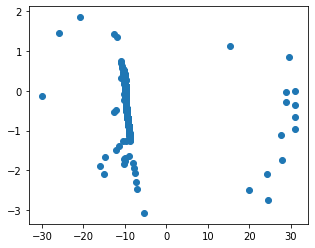

Iteration 40100; Gradient mag: 185.44818365410228; Objective: -27.502890176695647
Iteration 40200; Gradient mag: 188.68123942541695; Objective: -21.496968625160765
Iteration 40300; Gradient mag: 1216.6441553617738; Objective: -27.52830395695164
Iteration 40400; Gradient mag: 2360.192782905268; Objective: -28.152409095821
Iteration 40500; Gradient mag: 668.934241673478; Objective: -28.166149725036092
Iteration 40600; Gradient mag: 1819.7179125509917; Objective: -28.220965779856606
Iteration 40700; Gradient mag: 398.8733137667217; Objective: -27.23914414451742
Iteration 40800; Gradient mag: 1847.0020882564531; Objective: -28.611850689539136
Iteration 40900; Gradient mag: 1262.866964890838; Objective: -28.061478943223367
Iteration 41000; Gradient mag: 153.38270734078185; Objective: -27.091370589469303
Iteration 41100; Gradient mag: 874.328228823752; Objective: -27.11246881114424
Iteration 41200; Gradient mag: 406.8552089084388; Objective: -27.578907500861888
Iteration 41300; Gradient mag:

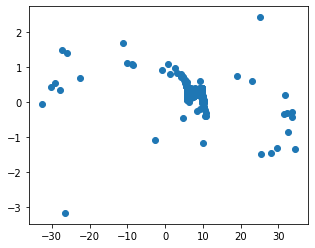

Iteration 45100; Gradient mag: 1833.2741760624945; Objective: -29.140073414636806
Iteration 45200; Gradient mag: 1654.2344686169915; Objective: -26.563561136551638
Iteration 45300; Gradient mag: 1984.6350039311026; Objective: -28.630325485177167
Iteration 45400; Gradient mag: 486.01955889201577; Objective: -24.62489243795563
Iteration 45500; Gradient mag: 643.1519987291002; Objective: -26.841149852905488
Iteration 45600; Gradient mag: 833.2379602463716; Objective: -28.071751540939193
Iteration 45700; Gradient mag: 940.749136076976; Objective: -27.973504181570355
Iteration 45800; Gradient mag: 1816.1320209209928; Objective: -28.243145685164674
Iteration 45900; Gradient mag: 1793.229883862518; Objective: -29.018935726198784
Iteration 46000; Gradient mag: 519.1766585126053; Objective: -29.823974903036685
Iteration 46100; Gradient mag: 3196.1141077604193; Objective: -28.822327332835084
Iteration 46200; Gradient mag: 370.87389105243216; Objective: -28.22070729008709
Iteration 46300; Gradien

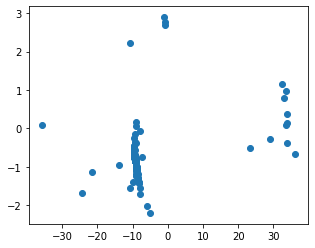

Iteration 50100; Gradient mag: 257.21060872846107; Objective: -29.70495804877341
Iteration 50200; Gradient mag: 1793.6364604428736; Objective: -29.593488998046634
Iteration 50300; Gradient mag: 1341.6204939923095; Objective: -29.857271863049945
Iteration 50400; Gradient mag: 20387.53553170074; Objective: -24.396143043089847
Iteration 50500; Gradient mag: 6236.708480694645; Objective: -29.249106554528428
Iteration 50600; Gradient mag: 257.76217636476423; Objective: -30.03378832370806
Iteration 50700; Gradient mag: 804.5083855972526; Objective: -29.794187998372276
Iteration 50800; Gradient mag: 374.65135562963945; Objective: -29.682881481988243
Iteration 50900; Gradient mag: 750.6305996667894; Objective: -29.950898766371992
Iteration 51000; Gradient mag: 698.7762650184911; Objective: -26.394634531516626
Iteration 51100; Gradient mag: 236.97956313576358; Objective: -29.452148218127306
Iteration 51200; Gradient mag: 95.3465894380399; Objective: -29.920493327664577
Iteration 51300; Gradient

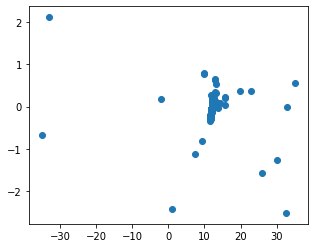

Iteration 55100; Gradient mag: 3754.2816945923973; Objective: -29.402508908518552
Iteration 55200; Gradient mag: 725.0921768544371; Objective: -29.375430451212175
Iteration 55300; Gradient mag: 2777.9750970210084; Objective: -29.466066363821025
Iteration 55400; Gradient mag: 1713.4578176534824; Objective: -29.464431901092794
Iteration 55500; Gradient mag: 3231.638045839219; Objective: -29.237878407354817
Iteration 55600; Gradient mag: 300.4842023908181; Objective: -29.523404100157197
Iteration 55700; Gradient mag: 1020.8580409771786; Objective: -29.342188174991364
Iteration 55800; Gradient mag: 169.319311715091; Objective: -29.61160579854615
Iteration 55900; Gradient mag: 847.0884961128015; Objective: -29.391166346211598
Iteration 56000; Gradient mag: 2837.7077239891305; Objective: -29.46920510821387
Iteration 56100; Gradient mag: 3994.408748121206; Objective: -29.41845730225147
Iteration 56200; Gradient mag: 2888.736645055007; Objective: -29.43011554817165
Iteration 56300; Gradient ma

In [2]:
K = 2
dim_z = 1
num_samples = 1000
num_iter = 10000
func = gmm

objective, gradient, unpack_params = gradient_create(func, 1e-7, dim_z, num_samples, K)

objectives = []
def callback(params, t, g):
    if t%100 == 0:
        print("Iteration {}; Gradient mag: {}; Objective: {}".format(t,
            np.linalg.norm(gradient(params, t)), objective(params, t)))
        objectives.append(objective(params, t))
    if t%5000 == 0:
        W, U, B = unpack_params(params)
        z0 = np.random.randn(num_samples, dim_z)
        z_prev = z0
        for k in range(K):
            w, u, b = W[k], U[k], B[k]
            u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
            z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
        z_K = z_prev
        plt.figure(figsize=(5,4))
#         plt.scatter(z_K[:,0], z_K[:,1])
        plt.hist(z_K, 100, density=True)
        plt.show()


init_W = 1*np.ones((K, dim_z))
init_U = 1*np.ones((K, dim_z))
init_b = 1*np.ones((K))
init_params = np.concatenate((init_W.flatten(), init_U.flatten(), init_b.flatten()))

variational_params = rmsprop(gradient, init_params, callback, num_iter, 5e-4)

In [3]:
W, U, B = unpack_params(variational_params)
z0 = np.random.randn(1000, dim_z)
z_prev = z0
for k in range(K):
    w, u, b = W[k], U[k], B[k]
    u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
    z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
z_K = z_prev

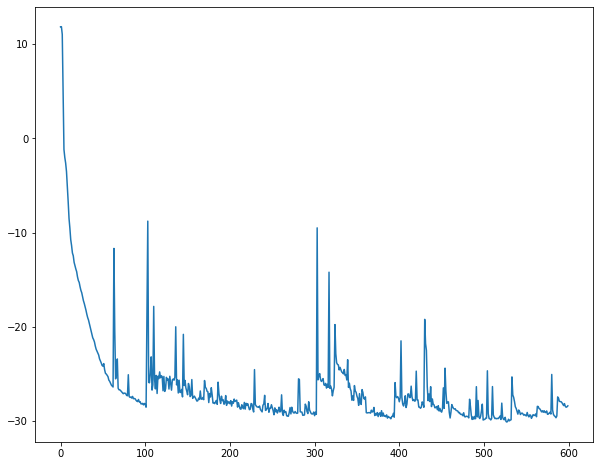

In [4]:
plt.figure(figsize=(10,8))
plt.plot(objectives)
plt.show()

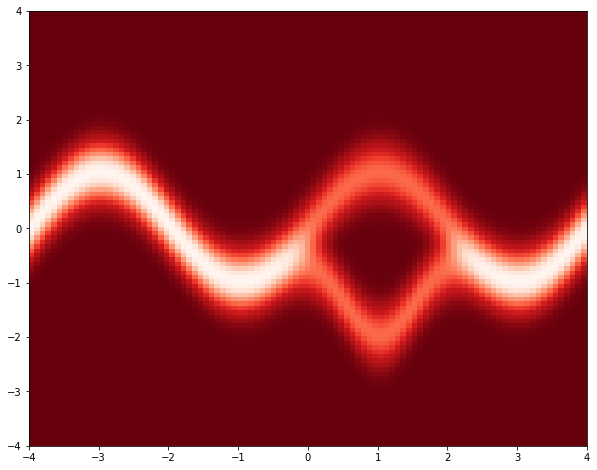

In [5]:
fig,ax=plt.subplots(1,1,figsize = (10,8))
nbins = 100
x, y = z0[:, 0], z0[:, 1]
xi, yi = numpy.mgrid[-4:4:nbins*1j, -4:4:nbins*1j]
zi = np.array([func(np.vstack([xi.flatten(), yi.flatten()])[:,i].reshape(-1,2)) for i in range(nbins**2)])
ax.pcolormesh(xi, yi, zi.reshape(xi.shape))
ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.Reds_r)
plt.scatter(z_K[:,0], z_K[:,1], alpha=0.2)
plt.xlim([-4, 4])
plt.ylim([-4, 4])
# plt.savefig('results/'+func.__name__+'/'+func.__name__+'_'+str(K)+'_'+str(num_iter)+'.png')
plt.show()

Iteration 100; Gradient mag: 0.21412527507645385; Objective: 0.36048780859771506
Iteration 200; Gradient mag: 0.2711770867555946; Objective: 0.529967104279303
Iteration 300; Gradient mag: 0.31581678182763845; Objective: 0.3285078071571663
Iteration 400; Gradient mag: 0.3396334036048581; Objective: 0.34496231429501156
Iteration 500; Gradient mag: 0.40397161340416843; Objective: 0.1976793730312565
Iteration 600; Gradient mag: 0.3944962370314737; Objective: 0.26685376788311443
Iteration 700; Gradient mag: 0.4161719757786407; Objective: 0.25291698800295037
Iteration 800; Gradient mag: 0.41964320804543387; Objective: 0.22260453164128075
Iteration 900; Gradient mag: 0.4210361414333731; Objective: 0.14194841003723824
Iteration 1000; Gradient mag: 0.3953218371934932; Objective: 0.12817666933789496


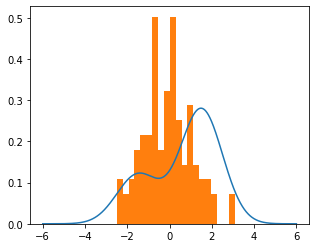

Iteration 1100; Gradient mag: 0.47691541638955565; Objective: 0.15248501715578133
Iteration 1200; Gradient mag: 0.41126945899117007; Objective: 0.15679186969331632
Iteration 1300; Gradient mag: 0.41069446768103474; Objective: 0.09233321439441115
Iteration 1400; Gradient mag: 0.43401903021305516; Objective: 0.07492506170708835
Iteration 1500; Gradient mag: 0.2599884015374914; Objective: 0.015814569578882585
Iteration 1600; Gradient mag: 0.37136694097561584; Objective: 0.0783557785459474
Iteration 1700; Gradient mag: 0.37212306021905595; Objective: 0.07508786390313116
Iteration 1800; Gradient mag: 0.3607536229590255; Objective: -0.0454730376917697
Iteration 1900; Gradient mag: 0.26093866449801806; Objective: -0.008774603101832345
Iteration 2000; Gradient mag: 0.2573730627866848; Objective: -0.004765840962995219


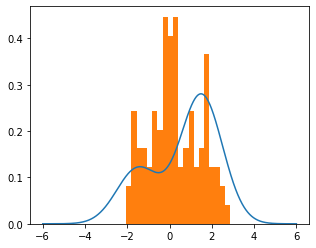

Iteration 2100; Gradient mag: 0.29320671082560534; Objective: -0.05468655645034687
Iteration 2200; Gradient mag: 0.32326287477515464; Objective: -0.021788967895588224
Iteration 2300; Gradient mag: 0.25385637233886066; Objective: -0.1418005185578554
Iteration 2400; Gradient mag: 0.24659610558646047; Objective: -0.1516696245108267
Iteration 2500; Gradient mag: 0.16672035548969386; Objective: -0.1679709007916466
Iteration 2600; Gradient mag: 0.2661488596868667; Objective: -0.18724523787863956
Iteration 2700; Gradient mag: 0.23657281221661702; Objective: -0.14953791030897104
Iteration 2800; Gradient mag: 0.21800384753497318; Objective: -0.20084021284631767
Iteration 2900; Gradient mag: 0.15040812583873497; Objective: -0.22350069632367778
Iteration 3000; Gradient mag: 0.21484340563822513; Objective: -0.2407807825341425


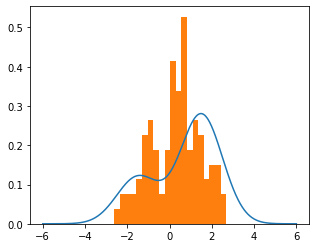

Iteration 3100; Gradient mag: 0.10199322449120135; Objective: -0.2043579683353421
Iteration 3200; Gradient mag: 0.09909798797519379; Objective: -0.21723156516311537
Iteration 3300; Gradient mag: 0.12381928409100076; Objective: -0.21703077754772335
Iteration 3400; Gradient mag: 0.18422954217526802; Objective: -0.21176596683629667
Iteration 3500; Gradient mag: 0.17453377131679418; Objective: -0.22790583427731803
Iteration 3600; Gradient mag: 0.09216663551789167; Objective: -0.22575196589191632
Iteration 3700; Gradient mag: 0.05083042262617389; Objective: -0.22929359688624026
Iteration 3800; Gradient mag: 0.13938833456718636; Objective: -0.1663680411243135
Iteration 3900; Gradient mag: 0.06465036471215563; Objective: -0.23837089218031204
Iteration 4000; Gradient mag: 0.04150101747913188; Objective: -0.25381097411380726


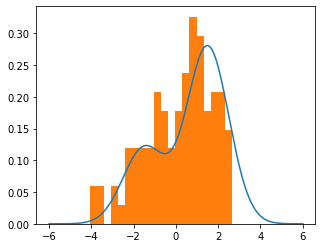

Iteration 4100; Gradient mag: 0.058021704640578424; Objective: -0.21898634096684727
Iteration 4200; Gradient mag: 0.10242582207367461; Objective: -0.21912732282603883
Iteration 4300; Gradient mag: 0.15814565928406726; Objective: -0.21913168247956727
Iteration 4400; Gradient mag: 0.017510202983915618; Objective: -0.24909262242259816
Iteration 4500; Gradient mag: 0.21226272001258406; Objective: -0.21267454331633262
Iteration 4600; Gradient mag: 0.15503531432148057; Objective: -0.23382044540806687
Iteration 4700; Gradient mag: 0.08553064201486284; Objective: -0.2617712048493416
Iteration 4800; Gradient mag: 0.0301628332946521; Objective: -0.2309010466352015
Iteration 4900; Gradient mag: 0.14971523887067364; Objective: -0.2360274627960763
Iteration 5000; Gradient mag: 0.09079449865984035; Objective: -0.23339040518411674


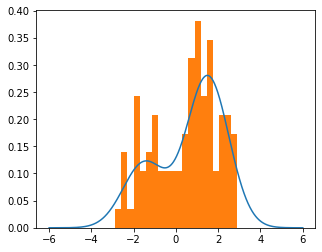

Iteration 5100; Gradient mag: 0.03497732635797967; Objective: -0.2325576976120646
Iteration 5200; Gradient mag: 0.12285414429305991; Objective: -0.2439098706120695
Iteration 5300; Gradient mag: 0.04957688435144393; Objective: -0.19364084212902463
Iteration 5400; Gradient mag: 0.05431895412439739; Objective: -0.22533824780766046
Iteration 5500; Gradient mag: 0.042644002218212476; Objective: -0.25749594854772634
Iteration 5600; Gradient mag: 0.0617564653701764; Objective: -0.19904162391965113
Iteration 5700; Gradient mag: 0.06130559003191518; Objective: -0.22609863230810956
Iteration 5800; Gradient mag: 0.14925823739757915; Objective: -0.2632397758513664
Iteration 5900; Gradient mag: 0.11697308567931905; Objective: -0.21851410092716964
Iteration 6000; Gradient mag: 0.0856267931209762; Objective: -0.24773551456077045


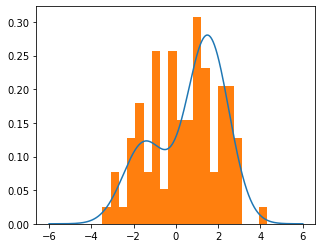

Iteration 6100; Gradient mag: 0.052044316607670574; Objective: -0.24411714101577037
Iteration 6200; Gradient mag: 0.025463366257553598; Objective: -0.2280583907374726
Iteration 6300; Gradient mag: 0.07816264566672534; Objective: -0.2848385480695304
Iteration 6400; Gradient mag: 0.10167022441349428; Objective: -0.2499687117365988
Iteration 6500; Gradient mag: 0.07182190488658315; Objective: -0.22731746242678064
Iteration 6600; Gradient mag: 0.14601792440405678; Objective: -0.22553225248698486
Iteration 6700; Gradient mag: 0.10010994667174737; Objective: -0.2185984969091473
Iteration 6800; Gradient mag: 0.05628121133910545; Objective: -0.24737772214623654
Iteration 6900; Gradient mag: 0.11977530729541196; Objective: -0.2425506599758784
Iteration 7000; Gradient mag: 0.14584145176055144; Objective: -0.2367168062637655


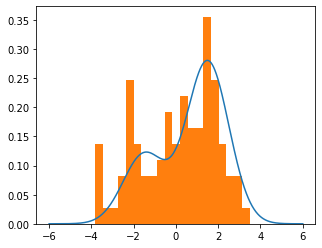

In [101]:
K = 1
dim_z = 1
num_samples = 100
num_iter = 7000
func = gmm

objective, gradient, unpack_params = gradient_create(func, 1e-7, dim_z, num_samples, K)

objectives = []
def callback(params, t, g):
    if (t+1)%100 == 0:
        print("Iteration {}; Gradient mag: {}; Objective: {}".format(t+1,
            np.linalg.norm(gradient(params, t)), objective(params, t)))
        objectives.append(objective(params, t))
    if (t+1)%1000 == 0:
        W, U, B = unpack_params(params)
        z0 = np.random.randn(num_samples, dim_z)
        z_prev = z0
        for k in range(K):
            w, u, b = W[k], U[k], B[k]
            u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
            z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
        z_K = z_prev
        samples = np.linspace(-6, 6, 1201)
        z = np.array([gmm(samples[i]) for i in range(samples.shape[0])])
        plt.figure(figsize=(5,4))
        idx = np.argsort(samples)
        plt.plot(samples[idx], z[idx])
        plt.hist(z_K, 20, density=True)
        plt.show()


init_W = 0.1*np.ones((K, dim_z))
init_U = 0.1*np.ones((K, dim_z))
init_b = 0.1*np.ones((K))
init_params = np.concatenate((init_W.flatten(), init_U.flatten(), init_b.flatten()))

variational_params = adam(gradient, init_params, callback, num_iter, 5e-4)

In [102]:
W, U, B = unpack_params(variational_params)
z0 = np.random.randn(1000, dim_z)
z_prev = z0
for k in range(K):
    w, u, b = W[k], U[k], B[k]
    u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
    z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
z_K = z_prev

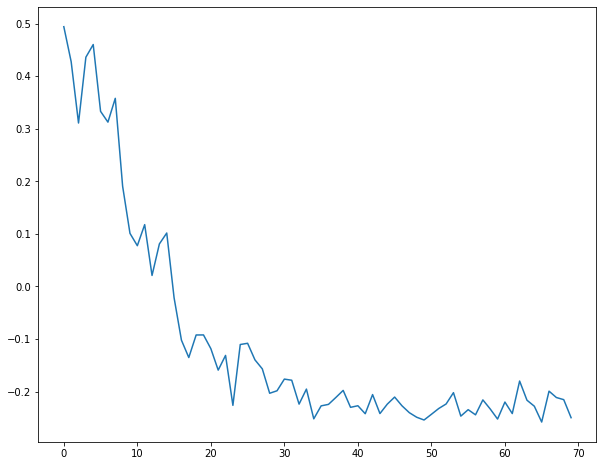

In [103]:
plt.figure(figsize=(10,8))
plt.plot(objectives)
plt.show()

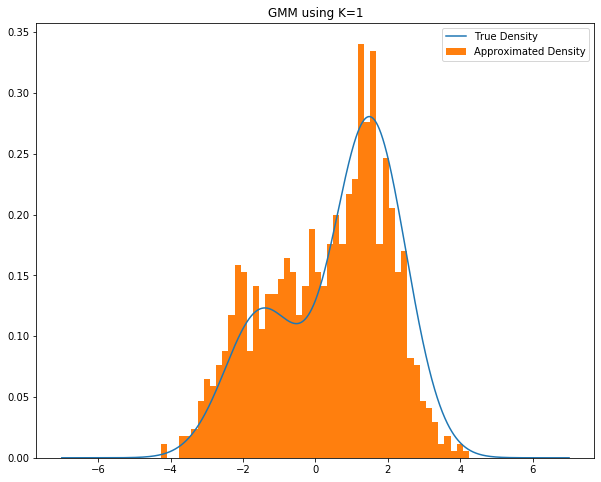

In [106]:
plt.figure(figsize=(10,8))
samples = np.linspace(-7, 7, 1401)
z = np.array([gmm(samples[i]) for i in range(samples.shape[0])])
idx = np.argsort(samples)
plt.plot(samples[idx], z[idx], label='True Density')
plt.hist(z_K, 50, label='Approximated Density', density=True)
plt.title('GMM using K={}'.format(K))
plt.legend()
plt.savefig('results/'+func.__name__+'/'+func.__name__+'_'+str(K)+'_'+str(num_iter)+'.png')
# plt.show()

In [ ]:
Ks = [1, 2, 3, 4]
dim_z = 1
num_samples = 100
num_iters = [5000, 6000, 7000, 8000, 10000]
func = gmm
for K in Ks:
    for num_iter in num_iters:
        objective, gradient, unpack_params = gradient_create(func, 1e-7, dim_z, num_samples, K)
        init_W = 0.1*np.ones((K, dim_z))
        init_U = 0.1*np.ones((K, dim_z))
        init_b = 0.1*np.ones((K))
        init_params = np.concatenate((init_W.flatten(), init_U.flatten(), init_b.flatten()))

        variational_params = adam(gradient, init_params, None, num_iter, 5e-4)

        W, U, B = unpack_params(variational_params)
        z0 = np.random.randn(1000, dim_z)
        z_prev = z0
        for k in range(K):
            w, u, b = W[k], U[k], B[k]
            u_hat = (m(np.dot(w,u)) - np.dot(w,u)) * (w / np.linalg.norm(w)) + u
            z_prev = z_prev + np.outer(h(np.matmul(z_prev, w) + b), u_hat)
        z_K = z_prev

        plt.figure(figsize=(10,8))
        samples = np.linspace(-7, 7, 1401)
        z = np.array([gmm(samples[i]) for i in range(samples.shape[0])])
        idx = np.argsort(samples)
        plt.plot(samples[idx], z[idx], label='True Density')
        plt.hist(z_K, 100, label='Approximated Density', density=True)
        plt.title('GMM using K={}'.format(K))
        plt.legend()
        plt.savefig('results/'+func.__name__+'/'+func.__name__+'_'+str(K)+'_'+str(num_iter)+'.png')            